#### Data Class

In [1]:
import random

class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: #Score of 4 or 5
            return Sentiment.POSITIVE

class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
        
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)

#### Load Data

In [2]:
import json
file_name = './data/books_small_10000.json'

reviews = []
with open(file_name) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'], review['overall']))
        
reviews[5].text

'I hoped for Mia to have some peace in this book, but her story is so real and raw.  Broken World was so touching and emotional because you go from Mia\'s trauma to her trying to cope.  I love the way the story displays how there is no "just bouncing back" from being sexually assaulted.  Mia showed us how those demons come for you every day and how sometimes they best you. I was so in the moment with Broken World and hurt with Mia because she was surrounded by people but so alone and I understood her feelings.  I found myself wishing I could give her some of my courage and strength or even just to be there for her.  Thank you Lizzy for putting a great character\'s voice on a strong subject and making it so that other peoples story may be heard through Mia\'s.'

#### Preparation of DAta

In [3]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(reviews, test_size=0.33, random_state=42)

train_container = ReviewContainer(training)

test_container = ReviewContainer(test)

In [4]:
train_container.evenly_distribute()
train_x = train_container.get_text()
train_y = train_container.get_sentiment()

test_container.evenly_distribute()
test_x = test_container.get_text()
test_y = test_container.get_sentiment()

print(train_y.count(Sentiment.POSITIVE))
print(train_y.count(Sentiment.NEGATIVE))

436
436


#### Bags of Words Vectorization

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

print(train_x[0])
print(train_x_vectors[0].toarray())

I liked the first one but got stuck on this one and do not have the will to move on reading
[[0. 0. 0. ... 0. 0. 0.]]


##### Word Clouds for positive and negative reviews

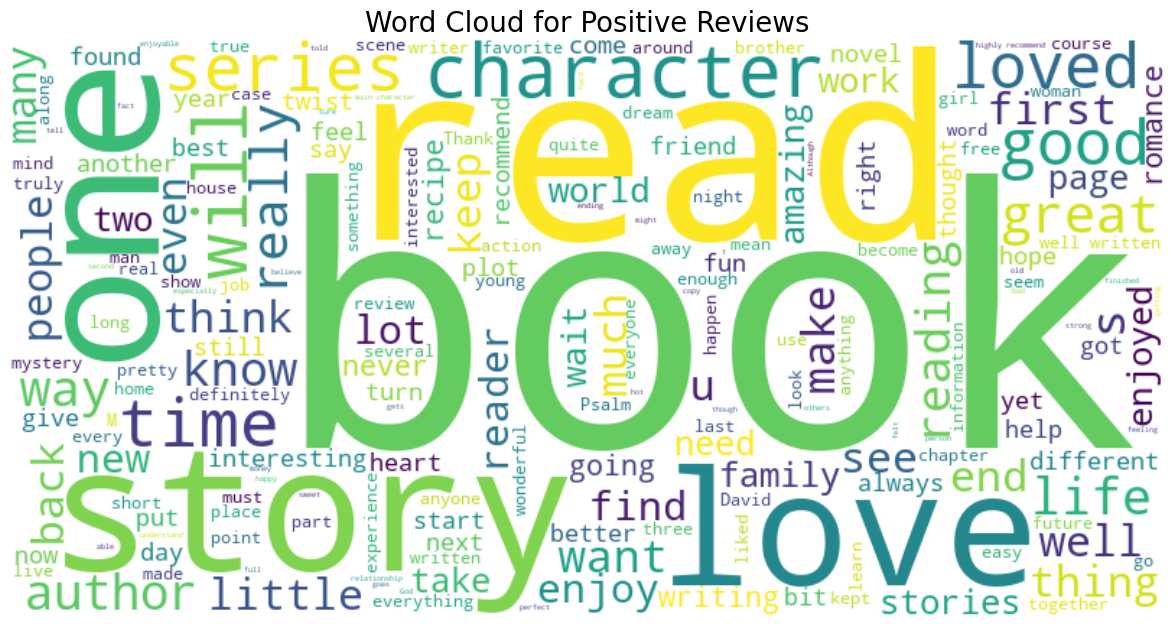

In [55]:
from wordcloud import WordCloud

# Combine all positive reviews
positive_reviews = ' '.join([text for text, sentiment in zip(train_x, train_y) if sentiment == 'POSITIVE'])

# Generate word cloud
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Plot
plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews', fontsize=20)
plt.savefig('positive_reviews.png')
plt.show()

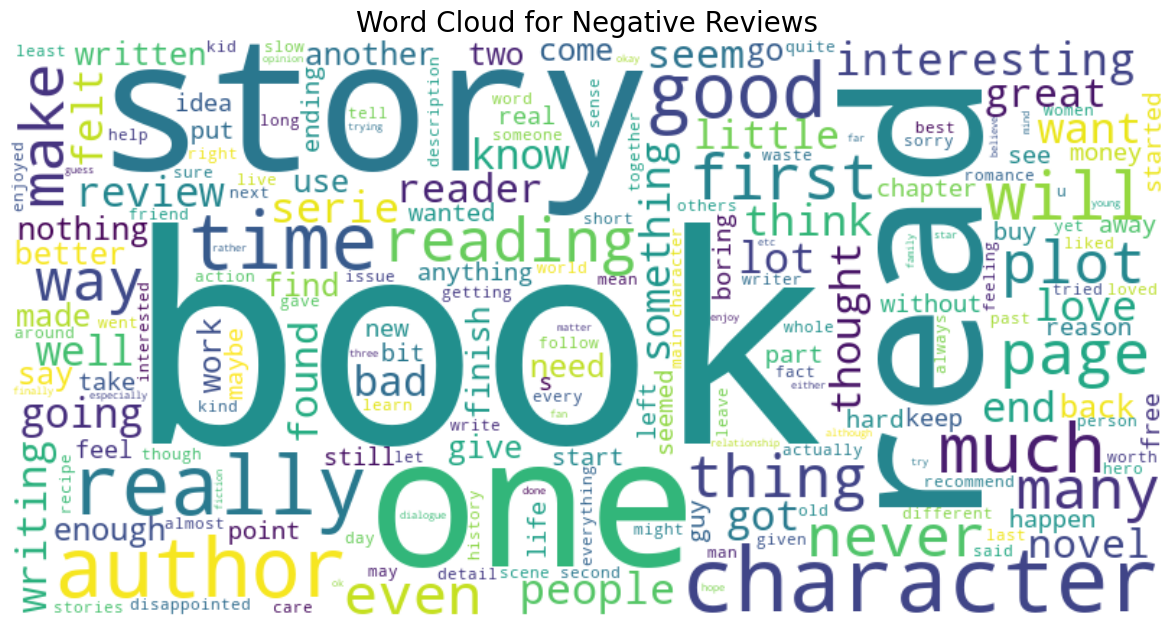

In [54]:
# Combine all negative reviews
negative_reviews = ' '.join([text for text, sentiment in zip(train_x, train_y) if sentiment == 'NEGATIVE'])

# Generate word cloud
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot
plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews', fontsize=20)
plt.savefig('negative_wordcloud.png')
plt.show()

### Classification

##### Linear SVM

In [6]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, train_y)

test_x[0]

clf_svm.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

In [16]:
print(test_x[1])
print(clf_svm.predict(test_x_vectors[1]))

How can it not have been obvious half way through the book? Very much surprised at Allingham. Will try her again for more of a surprise.
['NEGATIVE']


In [43]:
train_y[5]

'POSITIVE'

In [31]:
print(clf_svm.score(test_x_vectors, test_y))

0.8076923076923077


In [42]:
test_y[5]

'POSITIVE'

In [29]:
print(test_x[5])
clf_svm.predict(test_x_vectors[5])

Every time I read another book in this series I'm left with a big silly grin on my face.  Matt and Nicole's story was no different.Matt was always a bit of a mystery in the prior books. You just knew he had a dark side (I mean that in the best sense of the word of course-Wowza!!).I adored Nicole. She was such a wonderful heroine who wasn't weak yet was able to show her vulnerability and kind hearted towards everyone around her. She was an independent woman who had a successful business and a wonderful BFF. I loved her sense of humor and great banter with Matt. I wanted to hug her when she opened up to Matt.Matt and Nicole's initial meeting was HOT! Their chemistry was immediate and Matt assumed his role as Dom to perfection. His bossiness in the bedroom left me swooning.Matt and Nicole's journey evolved into an extremely sweet, passionate and lovely story.It's always such a treat to have the rest of the Montgomery clan playing a big parted in the stories. I laughed myself silly many ti

array(['POSITIVE'], dtype='<U8')

##### Making Predictions

In [45]:
# Sample new reviews
new_reviews = [
    "I absolutely loved this book, it was a fantastic read!",
    "The book was boring and I couldn't finish it."
]

new_reviews_vectors = vectorizer.transform(new_reviews)

new_predictions = clf_svm.predict(new_reviews_vectors)

for review, sentiment in zip(new_reviews, new_predictions):
    print(f"Review: \"{review}\"")
    print(f"Predicted Sentiment: {sentiment}\n")

Review: "I absolutely loved this book, it was a fantastic read!"
Predicted Sentiment: POSITIVE

Review: "The book was boring and I couldn't finish it."
Predicted Sentiment: NEGATIVE



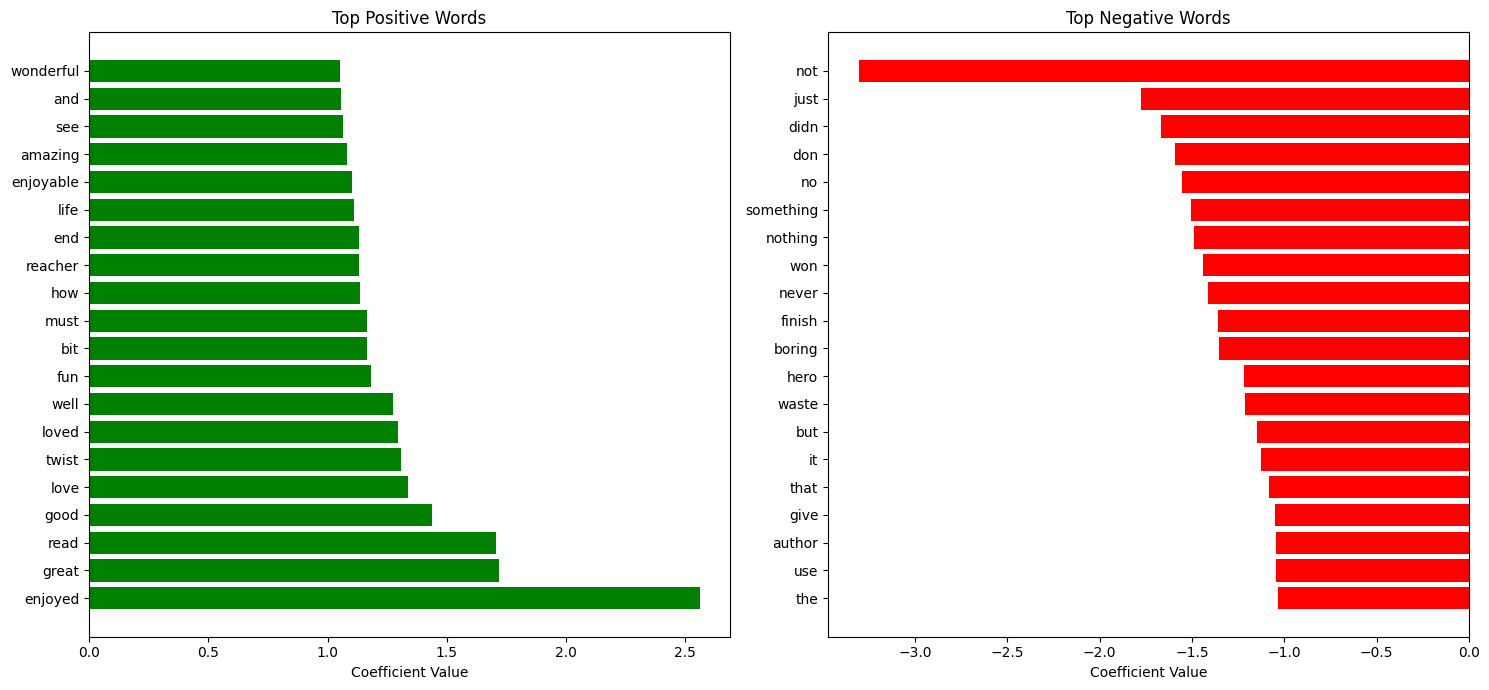

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names from the vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Get the coefficients from the trained Linear SVM
coefficients = clf_svm.coef_.toarray().flatten()

# Number of top features to display
top_n = 20

# Top positive features
top_positive_indices = np.argsort(coefficients)[-top_n:]
top_positive_features = feature_names[top_positive_indices]
top_positive_coefficients = coefficients[top_positive_indices]

# Top negative features
top_negative_indices = np.argsort(coefficients)[:top_n]
top_negative_features = feature_names[top_negative_indices]
top_negative_coefficients = coefficients[top_negative_indices]


# Plotting the top positive and negative features
plt.figure(figsize=(15, 7))

# Positive words
plt.subplot(1, 2, 1)
plt.barh(top_positive_features[::-1], top_positive_coefficients[::-1], color='green')
plt.xlabel('Coefficient Value')
plt.title('Top Positive Words')

# Negative words
plt.subplot(1, 2, 2)
plt.barh(top_negative_features[::-1], top_negative_coefficients[::-1], color='red')
plt.xlabel('Coefficient Value')
plt.title('Top Negative Words')
plt.tight_layout()
plt.savefig('top_features.png')
plt.show()

##### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

clf_dec.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

##### Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = DecisionTreeClassifier()
clf_gnb.fit(train_x_vectors, train_y)

clf_gnb.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

##### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)

clf_log.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

### Evaluation

In [61]:
print(clf_svm.score(test_x_vectors, test_y))
print(clf_dec.score(test_x_vectors, test_y))
print(clf_gnb.score(test_x_vectors, test_y))
print(clf_log.score(test_x_vectors, test_y))

0.8076923076923077
0.6466346153846154
0.6418269230769231
0.8028846153846154


In [66]:
# F1 Scores
from sklearn.metrics import f1_score

f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE])
# f1_score(test_y, clf_log.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE])

array([0.80582524, 0.80952381])

In [67]:
test_set = ['very fun', "bad book do not buy", 'horrible waste of time']
new_test = vectorizer.transform(test_set)

clf_svm.predict(new_test)

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE'], dtype='<U8')

In [77]:
from sklearn.metrics import classification_report

predictions_svm = clf_svm.predict(test_x_vectors)
predictions_dec = clf_dec.predict(test_x_vectors)
predictions_gnb = clf_gnb.predict(test_x_vectors)
predictions_log = clf_log.predict(test_x_vectors)

print("SVM Classification Report:\n", classification_report(test_y, predictions_svm))
print("Decision Tree Classification Report:\n", classification_report(test_y, predictions_dec))
print("Gaussian Naive Bayes Classification Report:\n", classification_report(test_y, predictions_gnb))
print("Logistic Regression Classification Report:\n", classification_report(test_y, predictions_log))

SVM Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.80      0.82      0.81       208
    POSITIVE       0.81      0.80      0.81       208

    accuracy                           0.81       416
   macro avg       0.81      0.81      0.81       416
weighted avg       0.81      0.81      0.81       416

Decision Tree Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.64      0.66      0.65       208
    POSITIVE       0.65      0.63      0.64       208

    accuracy                           0.65       416
   macro avg       0.65      0.65      0.65       416
weighted avg       0.65      0.65      0.65       416

Gaussian Naive Bayes Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.63      0.67      0.65       208
    POSITIVE       0.65      0.62      0.63       208

    accuracy                           0.64       416
   macro avg     

#### Tuning our model

In [68]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x_vectors, train_y)

C:\Users\samir\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

In [69]:
print(clf.score(test_x_vectors, test_y))


0.8076923076923077


In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# Initialize the SVC model
svc = SVC()

# Initialize GridSearchCV with the SVC model and the parameter grid
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')

# Fit the model with the training data
grid_search.fit(train_x_vectors, train_y)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Evaluate the model with the test data
test_score = grid_search.score(test_x_vectors, test_y)
print(f"Test Score: {test_score}")

Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Score: 0.8325517241379311
Test Score: 0.8076923076923077


### Saving model

#### Save Model

In [70]:
import pickle

with open('./models/sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

#### Load Model

In [72]:
with open('./models/sentiment_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [73]:
print(test_x[0])

loaded_clf.predict(test_x_vectors[0])

From the cover I thought this would be interesting. The SEX, SEX, SEX.... lots of SEX.... I read novels for good story lines, characters I care about, etc. Do not get this book even if free.


array(['NEGATIVE'], dtype='<U8')

In [83]:
# Print the first test review
print("First test review: ", test_x[0])

# Predict the sentiment of the first test review using the loaded model
predicted_sentiment = loaded_clf.predict(test_x_vectors[0])
print("Predicted sentiment: ", predicted_sentiment)

First test review:  From the cover I thought this would be interesting. The SEX, SEX, SEX.... lots of SEX.... I read novels for good story lines, characters I care about, etc. Do not get this book even if free.
Predicted sentiment:  ['NEGATIVE']


In [75]:
from sklearn.linear_model import Perceptron

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(train_x_vectors, train_y)  

Perceptron()

In [98]:
import pickle

# Save the trained GridSearchCV model
with open('./models/sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

print("Model saved successfully.")

Model saved successfully.


In [ ]:
with open('./models/sentiment_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

print("Model loaded successfully.")

Model loaded successfully.


In [94]:
new_reviews = [
    "I absolutely Loved the work Samir did on the project",
    "The work Samir did on the project was boring"
]

new_reviews_vectors = vectorizer.transform(new_reviews)
new_predictions = clf_svm.predict(new_reviews_vectors)

for review, sentiment in zip(new_reviews, new_predictions):
    print(f"Review: \"{review}\"")
    print(f"Predicted Sentiment: {sentiment}\n")

Review: "I absolutely Loved the work Samir did on the project"
Predicted Sentiment: POSITIVE

Review: "The work Samir did on the project was boring"
Predicted Sentiment: NEGATIVE



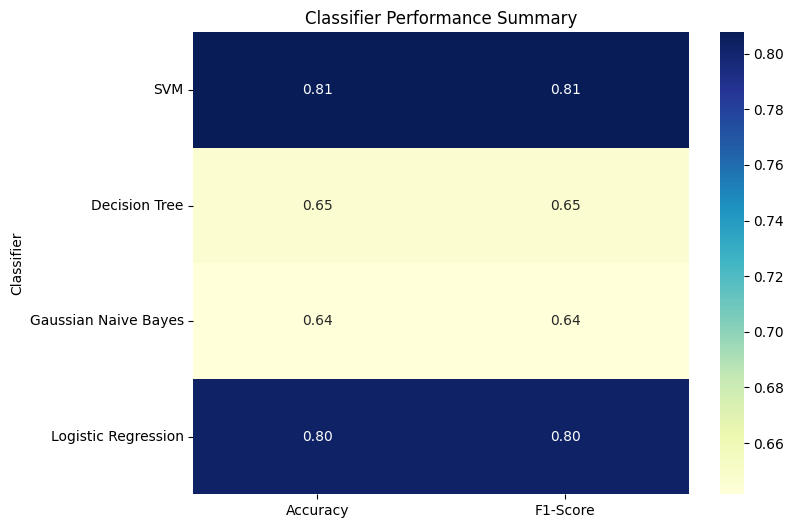

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Classifier': ['SVM', 'Decision Tree', 'Gaussian Naive Bayes', 'Logistic Regression'],
    'Accuracy': [
        clf_svm.score(test_x_vectors, test_y),
        clf_dec.score(test_x_vectors, test_y),
        clf_gnb.score(test_x_vectors, test_y),
        clf_log.score(test_x_vectors, test_y)
    ],
    'F1-Score': [
        f1_score(test_y, predictions_svm, average='weighted'),
        f1_score(test_y, predictions_dec, average='weighted'),
        f1_score(test_y, predictions_gnb, average='weighted'),
        f1_score(test_y, predictions_log, average='weighted')
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.heatmap(df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Classifier Performance Summary')
plt.savefig('classifier_performance.png')   
plt.show()